# Hyperparameter search

We can use the Python API to iteratively run a workflow with different injected variables.

In [1]:
import alpine as AlpineAPI

In [2]:
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Connection information

In [3]:
filename = "alpine_login.conf"

with open(filename, "r") as f:
    data = f.read()

conn_info = json.loads(data)

host = conn_info["host"]
port = conn_info["port"]
username = conn_info["username"]
password = conn_info["password"]

### Create a session and login

In [4]:
session = AlpineAPI.APIClient(host, port, username, password)

In [5]:
pprint(session.workfile.get(701), depth = 2)

{u'response': {u'associated_worklets': [],
               u'comment_count': 0,
               u'complete_json': True,
               u'dataset_ids': [],
               u'description': u'',
               u'entity_subtype': u'alpine',
               u'entity_type': u'workfile',
               u'execution_locations': [...],
               u'file_name': u'Random Forest Parameter Search',
               u'file_type': u'work_flow',
               u'id': 701,
               u'is_deleted': None,
               u'latest_version_id': None,
               u'link_url': None,
               u'owner': {...},
               u'recent_comments': [],
               u'status': u'idle',
               u'tags': [],
               u'user_modified_at': u'2017-02-28T21:35:54Z',
               u'version_info': {...},
               u'workspace': {...}}}


### Running a workflow and downloading the results

In [6]:
workflow_id = 701

In [7]:
process_id = session.workfile.process.run(workflow_id)

session.workfile.process.wait_until_finished(workflow_id,
                                             process_id,
                                             verbose=True,
                                             query_time=5,
                                             timeout=1000)

Workflow in progress for ~242.5 seconds.                                              


u'SUCCESS'

In [8]:
flow_results = session.workfile.process.download_results(workflow_id, process_id)
pprint(flow_results['outputs'], depth = 2)

[{u'isGenerateReport': True,
  u'node_meta_info': [...],
  u'out_id': 1493155451032.9402,
  u'out_title': u'magic04.csv',
  u'visualData': {...},
  u'visualType': 0},
 {u'isGenerateReport': True,
  u'node_meta_info': [...],
  u'out_id': 1493155489783.9727,
  u'out_title': u'Random Sampling',
  u'visualData': [...],
  u'visualType': 6},
 {u'isGenerateReport': True,
  u'node_meta_info': [...],
  u'out_id': 1493155499187.6677,
  u'out_title': u'Test Set',
  u'visualData': {...},
  u'visualType': 0},
 {u'isGenerateReport': True,
  u'node_meta_info': [...],
  u'out_id': 1493155506846.1965,
  u'out_title': u'Train Set',
  u'visualData': {...},
  u'visualType': 0},
 {u'isGenerateReport': True,
  u'node_meta_info': [...],
  u'out_id': 1493155616276.4927,
  u'out_title': u'Alpine Forest Classification',
  u'visualData': [...],
  u'visualType': 6},
 {u'isGenerateReport': True,
  u'out_id': 1493155680415.3167,
  u'out_title': u'Confusion Matrix',
  u'visualData': [...],
  u'visualType': 6}]


The downloaded results file is a summary of all the operator output in the workflow. In particular, it's a json file that we can manipulate or save to disk.

In [9]:
outfile = "Results_File_N_Trees_{}.fr".format(str(50))

with open(outfile, "w") as f:
    json.dump(flow_results, f)

### Parsing workflow results

When we convert the downloaded results to a Python object we get a nested dictionary/list object. I'm pulling two values out of the results: 

1. The overall prediction accuracy. This comes from the *Confusion Matrix* operator.
2. The number of trees. This comes from the *Alpine Forest Classification* operator.

This function parses the file to return those two values.

In [10]:
def parse_flow_results(workflow_id, process_id):
    flow_results = session.workfile.process.download_results(workflow_id, process_id)

    # Get accuracy from the confusion matrix
    conf_matrix_data = session.workfile.process.find_operator('Confusion Matrix', flow_results)
    acc = float(conf_matrix_data['visualData'][0]['visualData']['items'][2]['Class Recall'].split()[1])
    
    # Get number of trees from the Alpine Forest
    alpine_forest_data = session.workfile.process.find_operator('Alpine Forest Classification', flow_results)
    N = int(alpine_forest_data['visualData'][2]['visualData']['items'][0]['Average over All Trees'])
    
    return (N, acc)

### Workflow variables

Variables with different values can be inserted into workflows. They have to be formatted as below and are passed as an optioned argument to workflow run method.

In [11]:
ntrees = [5,10,25,50,75]
variables = [[{"name": "@n_trees", "value": str(N)}] for N in ntrees]

In [12]:
variables

[[{'name': '@n_trees', 'value': '5'}],
 [{'name': '@n_trees', 'value': '10'}],
 [{'name': '@n_trees', 'value': '25'}],
 [{'name': '@n_trees', 'value': '50'}],
 [{'name': '@n_trees', 'value': '75'}]]

### Run the workflow in a loop, extracting test accuracy

In [15]:
test_acc = []

for variable in variables:
    print("Running with work flow variable: {}".format(variable))
    process_id = session.workfile.process.run(workflow_id, variables=variable)
    session.workfile.process.wait_until_finished(workflow_id, process_id, verbose=True, query_time=5, timeout=1000)
    
    (N, acc) = parse_flow_results(workflow_id, process_id)
    test_acc.append(acc)
    
    print("For {} trees, test accuracy is {}".format(N, acc))
    print("")

Running with work flow variable: [{'name': '@n_trees', 'value': '5'}]
Workflow in progress for ~191.1 seconds.                                    
For 5 trees, test accuracy is 0.8530647

Running with work flow variable: [{'name': '@n_trees', 'value': '10'}]
Workflow in progress for ~207.0 seconds.                                       
For 10 trees, test accuracy is 0.861461

Running with work flow variable: [{'name': '@n_trees', 'value': '25'}]
Workflow in progress for ~250.3 seconds.                                               
For 25 trees, test accuracy is 0.8709068

Running with work flow variable: [{'name': '@n_trees', 'value': '50'}]
Workflow in progress for ~311.6 seconds.                                                           
For 50 trees, test accuracy is 0.875105

Running with work flow variable: [{'name': '@n_trees', 'value': '75'}]
Workflow in progress for ~363.1 seconds.                                                                     
For 75 trees, test accurac

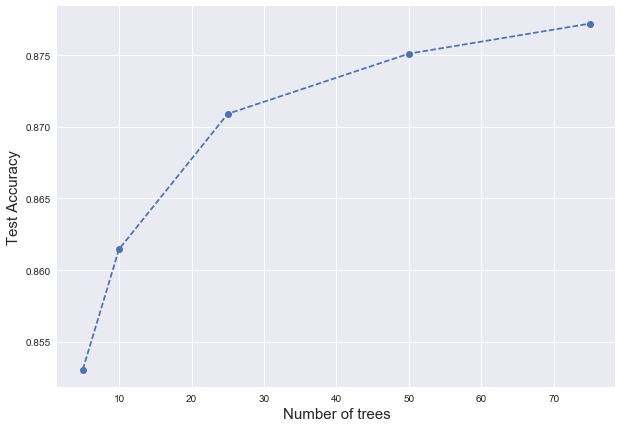

In [16]:
plt.figure(figsize = (10,7))
plt.plot(ntrees, test_acc, "o--")
plt.xlabel("Number of trees", size=15)
plt.ylabel("Test Accuracy", size=15);